## Face Mask Detection
  *Question 7*

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Subset, DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import glob
import zipfile
from torchvision.datasets import ImageFolder
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
zip_url = "https://empslocal.ex.ac.uk/people/staff/ad735/ECMM426/MaskedFace.zip"

# Directory to extract the contents
extract_dir = '/content/MaskedFace'

!wget {zip_url}

# Extract the contents
with zipfile.ZipFile('MaskedFace.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

--2024-03-06 04:10:39--  https://empslocal.ex.ac.uk/people/staff/ad735/ECMM426/MaskedFace.zip
Resolving empslocal.ex.ac.uk (empslocal.ex.ac.uk)... 144.173.112.51
Connecting to empslocal.ex.ac.uk (empslocal.ex.ac.uk)|144.173.112.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375156724 (358M) [application/zip]
Saving to: ‘MaskedFace.zip’

MaskedFace.zip      100%[===================>] 357.78M  14.5MB/s    in 21s     

2024-03-06 04:11:01 (17.0 MB/s) - ‘MaskedFace.zip’ saved [375156724/375156724]

Extracted files: ['train', 'val', '__MACOSX']


In [ ]:
!git clone https://github.com/pytorch/vision.git
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 473429, done.
remote: Counting objects: 100% (53887/53887), done.
remote: Compressing objects: 100% (2426/2426), done.
remote: Total 473429 (delta 51474), reused 53726 (delta 51380), pack-reused 419542
Receiving objects: 100% (473429/473429), 931.71 MiB | 14.32 MiB/s, done.
Resolving deltas: 100% (440573/440573), done.


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [ ]:
classes_to_num = { "with_mask": 1, "without_mask": 2, "mask_weared_incorrect": 3 }
class_num2str = {v: k for k, v in classes_to_num.items()}

train_dir_path = 'MaskedFace/train'
test_dir_path = 'MaskedFace/val'

import xml.etree.ElementTree as ET

def parse_xml_annotation(xml_path):

    tree = ET.parse(xml_path)
    root = tree.getroot()

    annotations = []
    classes = []
    boxes = []
    for member in root.findall('object'):
        filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None
        class_label = member.find('name').text
        bndbox = member.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        box = [xmin, ymin, xmax, ymax]
        boxes.append(box)
        classes.append(int(classes_to_num[class_label]))
    return filename, boxes, classes

# test ra XML file from the dataset
xml_files = sorted(glob.glob(os.path.join(test_dir_path, '*.xml')))# Assuming the second item is an XML file
xml_files = np.array(xml_files)
filename, boxes, classes = parse_xml_annotation(xml_files[0])

```
<annotation>
    <folder>images</folder>
    <filename>mask-562.png</filename>
    <size>
    <width>400</width>
    <height>210</height>
    <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
    <name>mask_weared_incorrect</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <occluded>0</occluded>
    <difficult>0</difficult>
    <bndbox>
    <xmin>163</xmin>
    <ymin>81</ymin>
    <xmax>241</xmax>
    <ymax>173</ymax>
    </bndbox>
    </object>
</annotation>
```

In [ ]:
import os
import glob
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class MaskedFaceTestDataset(Dataset):
    def __init__(self, root, transform=None):
        # super(MaskedFaceTestDataset, self).__init__()
        # self.root = root
        self.imgs = sorted(glob.glob(os.path.join(root, '*.png')))
        self.anno = sorted(glob.glob(os.path.join(root, '*.xml')))
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.imgs[index]
        anno_path = self.anno[index]
        filename, boxes, classes = parse_xml_annotation(anno_path)

        img = Image.open(img_path).convert("RGB")
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(classes, dtype=torch.int64)

        image_id = int(torch.tensor([index]))
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        num_objs = boxes.shape[0]
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        w,h = img.size
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)
        keep = (boxes[:, 3]>boxes[:, 1]) & (boxes[:, 2]>boxes[:, 0])
        boxes = boxes[keep]
        area = area[keep]
        iscrowd = iscrowd[keep]

        # img = transforms.ToTensor()(img)
        target = {}
        target['image_id'] = image_id
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        if self.transform is not None:
            img, target = self.transform(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = MaskedFaceTestDataset(root='MaskedFace/val')
dataset.__getitem__(12)

(<PIL.Image.Image image mode=RGB size=400x267>,
 {'image_id': 12,
  'boxes': tensor([[196.,  43., 236.,  91.],
          [ 41.,  73.,  65.,  95.],
          [263.,  62., 287.,  85.],
          [344.,  80., 377., 106.]]),
  'labels': tensor([1, 1, 1, 1]),
  'area': tensor([1920.,  528.,  552.,  858.]),
  'iscrowd': tensor([0, 0, 0, 0])})

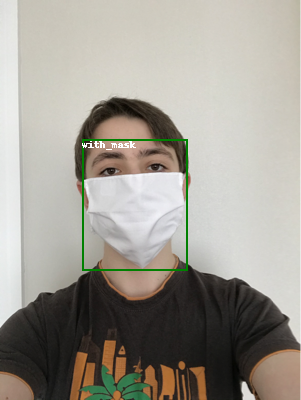

In [ ]:
from PIL import Image, ImageDraw
td = np.array(xml_files)
idx = np.random.randint(len(td))
filename, boxes, classes = parse_xml_annotation(td[idx])

image = Image.open(f'{test_dir_path}/{filename}')
draw = ImageDraw.Draw(image)
for i, item in enumerate(boxes):
    if(classes[i] == 1):
        draw.rectangle([(item[0], item[1]),(item[2], item[3])],outline='green', width=2)
        draw.text((item[0], item[1]), text=class_num2str[classes[i]])
    else:
        draw.rectangle([(item[0], item[1]),(item[2], item[3])],outline='red', width=2)
        draw.text((item[0], item[1]), text=class_num2str[classes[i]])
image

In [ ]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
from torchvision.transforms import v2 as Tr

def get_transform(train):
    return Tr.Compose([Tr.ToTensor()])

In [ ]:
DATA = {
    'train': MaskedFaceTestDataset('MaskedFace/train', transform=get_transform(train=True)),
    'test': MaskedFaceTestDataset('MaskedFace/val', transform=get_transform(train=False))
}

train_loader = torch.utils.data.DataLoader(DATA['train'], batch_size=2, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
test_loader = torch.utils.data.DataLoader(DATA['test'], batch_size=1, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(classes_to_num) + 1
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=40)
    evaluate(model, test_loader, device=device)
    # update the learning rate
    lr_scheduler.step()


Epoch: [0]  [  0/341]  eta: 0:03:30  lr: 0.000020  loss: 1.5099 (1.5099)  loss_classifier: 1.3749 (1.3749)  loss_box_reg: 0.1238 (0.1238)  loss_objectness: 0.0095 (0.0095)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 0.6177  data: 0.2192  max mem: 4461
Epoch: [0]  [ 40/341]  eta: 0:01:44  lr: 0.000607  loss: 0.5485 (0.9321)  loss_classifier: 0.2507 (0.5486)  loss_box_reg: 0.1448 (0.1350)  loss_objectness: 0.0787 (0.2223)  loss_rpn_box_reg: 0.0226 (0.0263)  time: 0.3372  data: 0.0056  max mem: 4461
Epoch: [0]  [ 80/341]  eta: 0:01:26  lr: 0.001195  loss: 0.4943 (0.7541)  loss_classifier: 0.1809 (0.3835)  loss_box_reg: 0.1858 (0.1733)  loss_objectness: 0.0472 (0.1700)  loss_rpn_box_reg: 0.0178 (0.0273)  time: 0.3180  data: 0.0054  max mem: 4461
Epoch: [0]  [120/341]  eta: 0:01:12  lr: 0.001783  loss: 0.3680 (0.6886)  loss_classifier: 0.1329 (0.3240)  loss_box_reg: 0.1372 (0.1861)  loss_objectness: 0.0429 (0.1515)  loss_rpn_box_reg: 0.0130 (0.0271)  time: 0.3240  data: 0.0051  max mem: 4461


In [ ]:
torch.save(model.state_dict(), 'best_model_weights.pth')

In [ ]:
model.load_state_dict(torch.load('/content/best_model_weights.pth'))

<All keys matched successfully>

### Testing on some random images


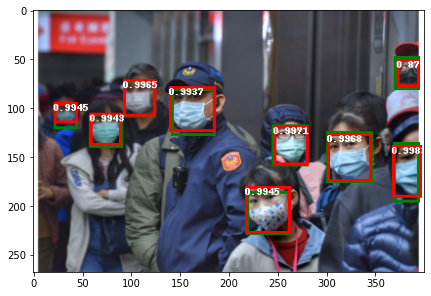

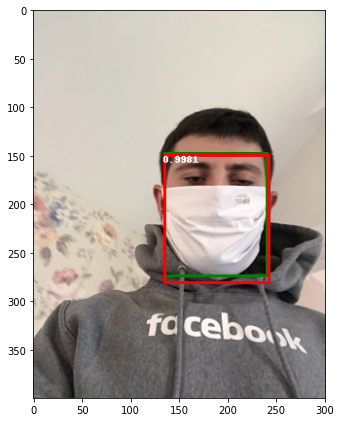

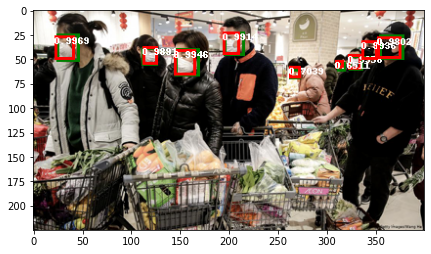

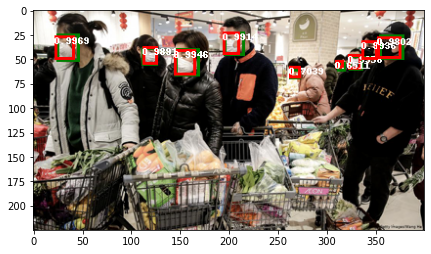

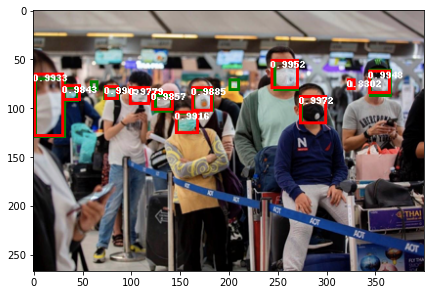

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7.0, 7.0)
plt.rcParams['figure.dpi'] = 72

any_indx = np.random.randint(0,len(DATA['test']),size=5)
model = model.cpu()
model.eval()
for i in any_indx:
    img, target = DATA['test'][i]
    label_boxes = np.array(target['boxes'])
    with torch.no_grad():
        prediction = model([img])
    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    draw = ImageDraw.Draw(image)
    # draw groundtruth
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]), (label_boxes[elem][2], label_boxes[elem][3])], outline ="green", width =3)
    for element in range(len(prediction[0]['boxes'])):
        boxes = prediction[0]['boxes'][element].cpu().numpy()
        score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals= 4)
        if score > 0.6:
            draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline ='red', width =3)
            draw.text((boxes[0], boxes[1]), text = str(score))
    plt.imshow(image)
    plt.show()

## Count Masks

In [ ]:
def count_masks(dataset):
  model.to(device)
  model.eval()
  counts = []
  total_mape = 0
  total_images = 0
  with torch.no_grad():
    for i in range(len(dataset)):
      img, target = dataset[i]
      targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in target.items()}]

      output = model([img.to(device)])  # Model predictions

      pred_counts = np.zeros(3, dtype=np.int64)

      for i, out in enumerate(output):
        pred_labels = out['labels'].cpu().numpy()
        pred_counts += np.array([
            np.sum(pred_labels == 1),  # with_mask
            np.sum(pred_labels == 2),  # without_mask
            np.sum(pred_labels == 3)   # mask_weared_incorrect
        ])

      counts.append(pred_counts)
      # Ground truth
      true_counts = np.zeros(3, dtype=np.int64)
      for t in targets:
          true_labels = t['labels'].cpu().numpy()
          true_counts += np.array([
              np.sum(true_labels == 1),  # with_mask class id
              np.sum(true_labels == 2),  # without_mask class id
              np.sum(true_labels == 3)   # mask_weared_incorrect class id
          ])

      mape = []
      for actual, pred in zip(true_counts, pred_counts):
        if actual == 0 and pred == 0:
          mape.append(0)
        elif actual == 0 and pred != 0:
          mape.append(0)
        else:
          mape.append(np.abs(actual - pred) / actual)
      total_mape += sum(mape)

      total_images += 1

  # Compute final MAPE score over all images
  mape_score = (total_mape / (total_images * 3)) * 100

  return np.array(counts, dtype=np.int64), mape_score


In [ ]:
counts, mape_score = count_masks(DATA['test'])
print("MAPE score:", mape_score)
print("Counts per image:\n", counts)

MAPE score: 25.779461267669245
Counts per image:
 [[31  4  6]
 [ 5  3  3]
 [ 1  0  0]
 [ 2  2  0]
 [10  6  3]
 [ 9  0  2]
 [ 3  0  0]
 [19  1  0]
 [ 1  0  0]
 [ 2  2  1]
 [ 6  2  2]
 [ 0  1  0]
 [ 7  0  0]
 [ 4  0  0]
 [ 2  4  2]
 [ 6  4  1]
 [18  2  3]
 [ 2  0  1]
 [ 2  3  1]
 [ 8  1  0]
 [ 7  0  1]
 [ 1  0  0]
 [ 2  0  1]
 [ 2  2  2]
 [14  1  0]
 [ 1  0  0]
 [17  2  2]
 [ 3 14  1]
 [ 1  0  0]
 [15  1  1]
 [ 0  1  0]
 [12  2  1]
 [53  1  4]
 [ 2  0  1]
 [ 1  0  0]
 [17  6  3]
 [ 2  0  0]
 [ 3  0  0]
 [27 23 10]
 [11 12 12]
 [ 3  3  1]
 [ 1  0  0]
 [ 1  0  0]
 [ 9  0  1]
 [ 0  1  0]
 [ 1  2  1]
 [12  2  0]
 [ 1  0  1]
 [ 1  0  0]
 [ 5  4  3]
 [23  2  4]
 [ 8  1  3]
 [ 7  4  3]
 [ 4  0  0]
 [ 9  0  1]
 [ 8  0  2]
 [ 1  0  0]
 [ 0  1  0]
 [ 5  0  1]
 [ 4  0  0]
 [ 1  3  0]
 [ 1  1  1]
 [ 6  0  0]
 [ 1  0  0]
 [ 2  1  1]
 [ 8  0  0]
 [ 1  0  0]
 [ 3  1  1]
 [ 5  0  0]
 [ 3  0  1]
 [ 3  2  2]
 [ 7  1  1]
 [ 0  1  0]
 [20  2  2]
 [ 1  6  2]
 [11  6  5]
 [ 1  0  0]
 [ 1  0  0]
 [ 1  0  0]
 [